## Transfer Learning

### initialize the libraries

In [96]:
import wandb
from wandb.keras import WandbCallback
run = wandb.init(project='baselines', entity='gijstimmerij', reinit=True)

In [2]:
from importlib.machinery import SourceFileLoader
somemodule = SourceFileLoader('tcn', r'C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\keras-tcn-master\tcn\tcn.py').load_module()

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tsai.all import *
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
import tensorflow.keras as keras
import tensorflow.keras.backend as K


In [81]:
columns = ["id", "cycle", "op1", "op2", "op3", "sensor1", "sensor2", "sensor3", "sensor4", "sensor5", "sensor6", "sensor7", "sensor8",
           "sensor9", "sensor10", "sensor11", "sensor12", "sensor13", "sensor14", "sensor15", "sensor16", "sensor17", "sensor18", "sensor19", "sensor20", "sensor21", "sensor22", "sensor23"]

train=pd.read_csv(r"C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData\train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv(r"C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData\test_FD001.txt",sep=" ",names=columns)
test_results=pd.read_csv(r"C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData\RUL_FD001.txt",sep=" ",header=None)

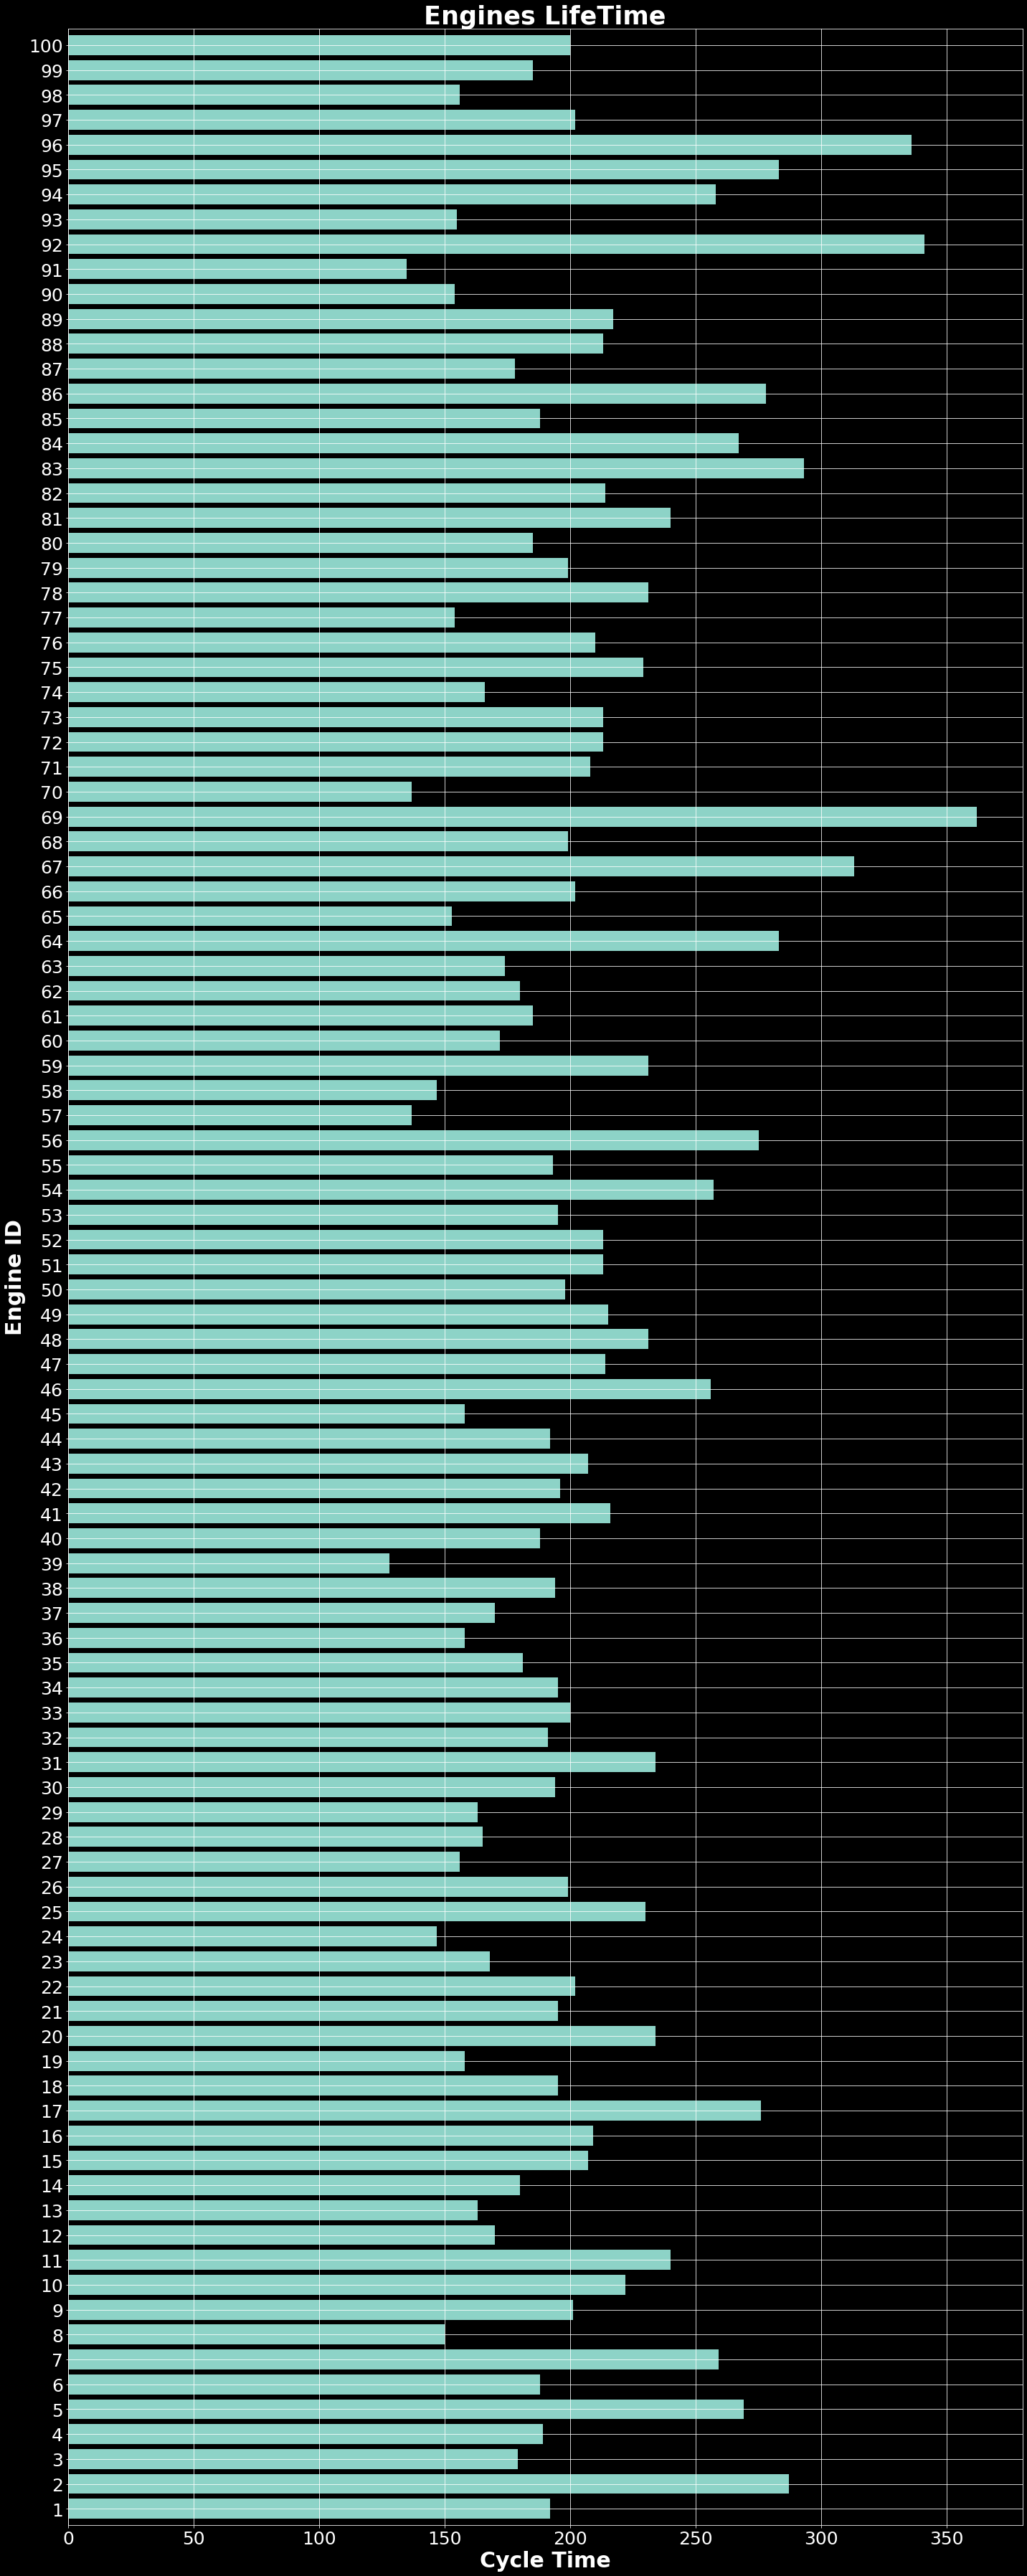

In [7]:
plt.style.use('dark_background')
plt.figure(figsize=(20,50))
ax=train.groupby('id')['cycle'].max().plot(kind='barh',width=0.8, stacked=True,align='center',rot=0)
plt.title('Engines LifeTime',fontweight='bold',size=35)
plt.xlabel('Cycle Time',fontweight='bold',size=30)
plt.xticks(size=25)
plt.ylabel('Engine ID',fontweight='bold',size=30)
plt.yticks(size=25)
plt.grid(True)
plt.tight_layout()
plt.show()

## Data preparation

In [82]:
test_results.columns = ["rul", "null"]
test_results.drop(["null"], axis=1, inplace=True)
test_results['id'] = test_results.index+1
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
test_results['rul_failed']=test_results['rul']+rul['max']
test_results.drop(["rul"],axis=1,inplace=True)
test=test.merge(test_results,on=['id'],how='left')
test["remaining_cycle"]=test["rul_failed"]-test["cycle"]

df_train=train.drop(["sensor22","sensor23"],axis=1)
df_test=test.drop(["sensor22","sensor23", "rul_failed"],axis=1)

df_train['remaining_cycle'] = df_train.groupby(['id'])['cycle'].transform(max)-df_train['cycle']

## option for binary classification

In [83]:
cycle=30
df_train['label'] = df_train['remaining_cycle'].apply(lambda x: 1 if x <= cycle else 0)
df_test['label'] = df_test['remaining_cycle'].apply(lambda x: 1 if x <= cycle else 0)

op_set=["op"+str(i) for i in range(1,4)]
sensor=["sensor"+str(i) for i in range(1,22)]

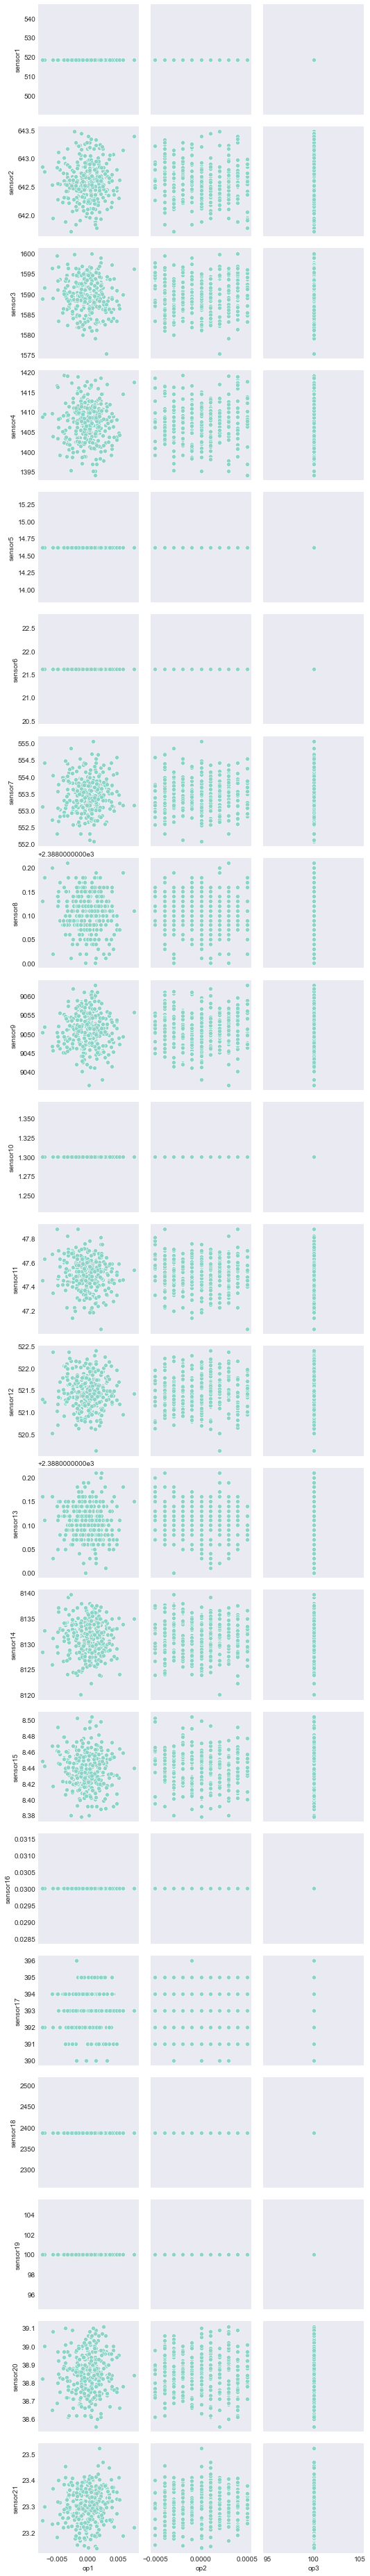

In [12]:
plt.style.use('seaborn-dark')
ax=sb.pairplot(test.query("cycle"),x_vars=op_set,y_vars=sensor,palette="husl")

### Delete the useless variables

In [84]:
df_test.drop(["cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19"],axis=1,inplace=True)
X_train = df_train.drop(["id","cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19","remaining_cycle","label"],axis=1)
X_test = df_test.drop(['remaining_cycle', 'label', 'id'],axis=1)
y_test = df_test.remaining_cycle
y = df_train.remaining_cycle
print('x shape : ', X_train.shape)
print('y shape : ', y.shape)

tsai_df = df_train.drop(["cycle","op3","sensor1","sensor5","sensor6","sensor10","sensor16","sensor18","sensor19","label"],axis=1)
tsai_df_test = df_test.drop(["label"],axis=1)


x shape :  (20631, 16)
y shape :  (20631,)


### Create smaller dataset with less engines

In [85]:
df_id_1_5 = tsai_df[tsai_df['id'] <= 5]
df_id_1_5_test = tsai_df_test[tsai_df_test['id'] <= 5]


### Normalize the data

In [86]:
gen = MinMaxScaler(feature_range=(0, 1))
data = gen.fit_transform(X_test)
data = pd.DataFrame(data)
data=np.nan_to_num(data)

pt = PowerTransformer()
scaled_X_test = pt.fit_transform(data)

scaled_df_test = pd.DataFrame(scaled_X_test)
scaled_df_test['RUL'] = y_test
scaled_df_test['id'] = df_test.id
scaled_df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,RUL,id
0,1.049365,1.004600,1.333227,-0.543820,-0.981745,0.157202,-0.501657,-0.734950,-1.135844,-0.112400,-0.698911,-1.521652,-0.692054,-0.435852,-0.266363,0.420595,142,1
1,-1.220564,-1.035151,-2.026229,0.095924,-1.467193,1.720949,-1.077473,-0.259251,0.487480,0.721475,-0.143646,0.182103,-1.649791,0.378493,0.899581,0.647087,141,1
2,0.140862,0.344897,-0.000094,-0.207106,-0.467327,0.483115,-0.317637,0.000826,0.487480,0.351776,-0.698911,-0.907151,0.657711,0.378493,1.361062,0.966019,140,1
3,1.913041,0.007977,-0.050265,-0.786268,0.307571,0.420181,-0.689532,-1.352331,-0.667106,-0.703805,-0.325176,-0.561267,-1.201106,-1.300958,0.748684,0.423078,139,1
4,0.640456,0.007977,0.124510,-0.156604,-0.375254,0.562352,-1.077473,-1.453359,-0.498585,0.701649,-0.698911,-0.979154,-0.769737,-2.225587,0.673786,0.919656,138,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,2.231376,0.007977,1.822924,2.173171,1.574625,-0.560445,-0.881417,3.751023,1.353767,-1.767171,-1.288265,4.158266,1.520245,1.148940,-1.652391,-1.589975,24,100
13092,-0.494678,-0.334082,1.779129,1.487011,2.325282,-0.822779,-0.317637,3.721800,0.956764,-1.234850,0.381065,4.091635,0.887575,1.880977,-2.136804,-0.723323,23,100
13093,-0.267740,-1.035151,2.253302,1.010007,0.365717,-1.063189,0.713093,3.823968,0.819230,-1.030634,-0.510221,4.261843,1.068803,1.880977,-1.836884,-1.509363,22,100
13094,-1.719319,0.344897,1.866578,1.356678,2.011041,-0.616408,0.039405,3.855726,1.002015,-0.786960,0.209360,4.342249,1.508112,1.880977,-1.590139,-0.804552,21,100


In [87]:
data = gen.fit_transform(X_train)
data = pd.DataFrame(data)
data=np.nan_to_num(data)

scaled_X_train = pt.fit_transform(data)

scaled_df_train = pd.DataFrame(scaled_X_train)
scaled_df_train['RUL'] = y
scaled_df_train['id'] = df_train.id
scaled_df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,RUL,id
0,-0.319754,-1.391687,-1.871061,-0.081738,-0.932431,1.165602,-0.463375,-1.241598,-0.180157,0.270006,-1.091345,-0.118842,-0.562870,-0.764000,1.426654,1.242484,191,1
1,0.872021,-1.031749,-1.079195,0.263809,-0.601489,0.381987,-0.783002,-1.473454,-0.100809,1.241006,-0.299444,-0.711710,-0.209418,-0.764000,1.037347,1.292268,190,1
2,-1.950307,1.013855,-0.632442,-0.370142,-0.468676,1.032163,-0.159131,-0.595354,-1.045084,1.477500,-0.925346,-0.556074,-0.613173,-2.350598,0.724148,0.465476,189,1
3,0.320582,0.013119,-0.632442,-1.306119,-0.764661,1.287388,0.270731,-0.910192,-1.740645,2.263380,-0.151844,-0.504130,-2.262630,-0.764000,0.302629,0.766684,188,1
4,-0.865918,-0.677944,-0.589021,-1.294771,-0.223683,0.694398,-0.463375,-0.410588,-0.998474,1.092373,-0.763292,-0.506706,-0.276973,-0.073644,0.421056,1.086014,187,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.182819,-1.031749,1.543554,1.200045,1.940086,-1.970282,1.282952,0.313653,1.779560,-2.224517,2.029475,-0.196707,1.373418,2.194637,-1.695146,-2.513125,4,100
20627,-0.729616,-1.758314,1.627183,2.096288,2.314491,-2.407067,1.727085,0.288926,1.698603,-2.057885,1.611158,-0.283143,1.763772,1.146364,-2.462563,-1.196759,3,100
20628,0.183090,0.013119,1.425039,1.825290,1.904545,-2.348902,1.832507,0.336315,1.832728,-1.746163,1.824332,0.058218,2.730644,2.666507,-1.909744,-2.752725,2,100
20629,-0.502091,1.013855,1.094574,2.195198,1.771953,-2.534263,1.935820,0.752875,2.560941,-2.066886,1.718778,-0.068856,2.259970,1.146364,-2.499385,-1.915684,1,100


In [90]:
data = gen.fit_transform(df_id_1_5[['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
       'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor17', 'sensor20', 'sensor21']])
data = pd.DataFrame(data)
data=np.nan_to_num(data)

scaled_X_reduced = pt.fit_transform(data)

scaled_df_reduced = pd.DataFrame(scaled_X_reduced)
scaled_df_reduced['RUL'] = df_id_1_5.remaining_cycle
scaled_df_reduced['id'] = df_id_1_5.id
scaled_df_reduced

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,RUL,id
0,-0.357990,-1.489007,-1.504330,0.246897,-0.493260,0.737824,0.082272,-1.404846,0.305539,-0.224681,-0.605082,-0.412346,-0.162685,-0.367682,1.101677,0.921845,191,1
1,0.861512,-1.118382,-0.695514,0.558716,-0.152739,-0.106093,-0.283003,-1.637301,0.379376,0.810762,0.263252,-1.010674,0.190194,-0.367682,0.679074,0.977673,190,1
2,-2.037626,0.940007,-0.258314,-0.023048,-0.020550,0.587784,0.414865,-0.765892,-0.567829,1.081424,-0.416660,-0.852481,-0.214298,-2.040598,0.349261,0.087890,189,1
3,0.298046,-0.057835,-0.258314,-0.964721,-0.318626,0.876968,0.860933,-1.075505,-1.367897,2.028916,0.416831,-0.799861,-2.118857,-0.367682,-0.079651,0.402703,188,1
4,-0.919089,-0.756858,-0.216537,-0.952666,0.216753,0.219504,0.082272,-0.585709,-0.517439,0.644233,-0.236056,-0.802469,0.124051,0.281920,0.039074,0.748224,187,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,1.284772,-1.118382,2.098588,2.119124,1.744351,-2.068789,1.488993,1.953068,1.783215,-2.046159,0.706773,1.895517,2.262451,1.327257,-2.261291,-1.868718,4,5
1112,-0.030157,-0.756858,1.531668,2.449288,2.264575,-1.478369,1.908792,1.942661,2.127376,-2.169030,1.225873,1.958941,2.048299,2.466082,-1.636953,-1.422358,3,5
1113,0.814517,0.281002,2.009194,2.455875,2.062557,-1.979063,0.718718,1.944179,2.156306,-2.123064,1.569673,1.937178,2.102290,2.130611,-1.846845,-2.013801,2,5
1114,1.520154,-0.756858,2.367582,2.392712,2.273284,-1.571980,1.373422,1.932687,1.989394,-1.857703,1.225873,2.040929,1.963482,2.130611,-1.744446,-1.691980,1,5


In [91]:
data = gen.fit_transform(df_id_1_5_test[['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
       'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
       'sensor17', 'sensor20', 'sensor21']])
data = pd.DataFrame(data)
data=np.nan_to_num(data)

scaled_X_reduced_test = pt.fit_transform(data)

scaled_df_reduced_test = pd.DataFrame(scaled_X_reduced_test)
scaled_df_reduced_test['RUL'] = df_id_1_5_test.remaining_cycle
scaled_df_reduced_test['id'] = df_id_1_5_test.id
scaled_df_reduced_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,RUL,id
0,0.957257,1.116762,1.239873,-1.013616,-1.971451,0.916152,-1.683020,-0.349192,-2.255715,0.640337,-2.177369,-1.708237,-1.457171,-0.894980,0.122410,1.142566,142,1
1,-1.245728,-0.976556,-2.838992,-0.271449,-2.552995,2.796805,-2.357869,0.630862,-0.127363,1.911831,-1.332460,2.500195,-2.645740,0.088735,1.600433,1.426150,141,1
2,0.059888,0.475576,-0.454271,-0.627913,-1.313878,1.342527,-1.448921,1.235264,-0.127363,1.356068,-2.177369,-0.431333,0.314932,0.088735,2.153351,1.818680,140,1
3,1.828331,0.136056,-0.515983,-1.284627,-0.236199,1.261811,-1.912609,-1.423487,-1.737189,-0.303573,-1.614938,0.395950,-2.095609,-1.878605,1.415972,1.145697,139,1
4,0.550889,0.136056,-0.300383,-0.569123,-1.191466,1.443100,-2.357869,-1.581379,-1.533486,1.882332,-2.177369,-0.593092,-1.555610,-2.862125,1.323712,1.762097,138,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,0.640837,0.136056,0.911907,0.678456,-0.214864,-0.105517,2.259228,0.623805,-0.818291,-0.948455,1.243119,-0.935449,0.029571,0.088735,0.214950,-2.180808,95,5
406,1.002661,1.714794,0.881982,0.090632,0.268455,-2.051602,-0.213760,-0.871363,1.210305,-1.981516,1.243119,-0.572941,0.087718,0.088735,0.492435,0.895448,94,5
407,0.461147,-0.588110,0.309790,0.685733,0.343501,0.462278,0.309076,0.565074,2.023665,-1.368099,0.378398,-0.613223,0.509829,0.088735,0.029846,-1.144233,93,5
408,-1.585135,0.136056,0.340082,0.841246,1.650630,-1.258467,-0.213760,1.076908,-0.892306,-0.112094,-0.194776,-0.218595,-0.694111,1.072532,-1.547620,0.021418,92,5


### Apply a sliding windon panel to the data

In [92]:
window_len = 30
swp_X, swp_y = SlidingWindowPanel(window_len=window_len, unique_id_cols=[
                                  'id'], get_x=[i for i in range(16)], get_y=['RUL'], stride=1)(scaled_df_train)

swp_X_test, swp_y_test = SlidingWindowPanel(window_len=window_len, unique_id_cols=[
                                            'id'], get_x=[i for i in range(16)], get_y=['RUL'], stride=1)(scaled_df_test)


swp_X_reduced, swp_y_reduced = SlidingWindowPanel(window_len=window_len, unique_id_cols=[
                                  'id'], get_x=[i for i in range(16)], get_y=['RUL'], stride=1)(scaled_df_reduced)

swp_X_reduced_test, swp_y_reduced_test = SlidingWindowPanel(window_len=window_len, unique_id_cols=[
                                  'id'], get_x=[i for i in range(16)], get_y=['RUL'], stride=1)(scaled_df_reduced_test)                                 

check_data(swp_X, swp_y)

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated
processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated
processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated
processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated
X      - shape: [17631 samples x 16 features x 30 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (17631,)  type: ndarray  dtype:int64  isnan: 0


In [14]:
output_path = r'C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\output-tcn-tsai'
model_path = output_path+r'\model.h5'

data_path = r'C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData'

In [15]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
        
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [93]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

conda activate tf-gpu

In [94]:
from tcn import TCN

##output tcn2
nb_features = swp_X.shape[2]
nb_out = 1


i = Input(shape=(16, nb_features))
#m = TCN()(i)
#m = Dense(1, activation='linear')(m)

m = TCN(nb_filters=32,dropout_rate = 0.2,dilations=[1, 2, 4, 8, 16, 32] ,return_sequences=True)(i)
m = TCN(nb_filters=16,dropout_rate = 0.2,dilations=[1, 2, 4, 8, 16, 32] ,return_sequences=False)(m)
m = Dense(1, activation='linear')(m)
model = Model(inputs=[i], outputs=[m])


model.summary()

model.compile('adam', 'mae')
#model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
model.compile(loss=root_mean_squared_error, optimizer='adam',metrics=['mae',r2_keras,root_mean_squared_error])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 30)]          0         
_________________________________________________________________
tcn_2 (TCN)                  (None, 16, 32)            31232     
_________________________________________________________________
tcn_3 (TCN)                  (None, 16)                8224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 39,473
Trainable params: 39,473
Non-trainable params: 0
_________________________________________________________________


In [97]:
history = model.fit(swp_X, swp_y.astype('float'), epochs=100, batch_size=200, validation_split=0.05, verbose=2,
                    callbacks=[keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0), WandbCallback()])

run.finish()

Epoch 1/100
84/84 - 11s - loss: 95.0086 - mae: 74.1235 - r2_keras: -2.2297e+00 - root_mean_squared_error: 94.9133 - val_loss: 56.3787 - val_mae: 47.2666 - val_r2_keras: -5.0132e-01 - val_root_mean_squared_error: 52.7593
Epoch 2/100
84/84 - 2s - loss: 59.4487 - mae: 45.1518 - r2_keras: 0.0608 - root_mean_squared_error: 59.4341 - val_loss: 51.0280 - val_mae: 42.9566 - val_r2_keras: -2.9336e-01 - val_root_mean_squared_error: 48.0899
Epoch 3/100
84/84 - 2s - loss: 52.8376 - mae: 39.7783 - r2_keras: 0.2560 - root_mean_squared_error: 52.8456 - val_loss: 44.8315 - val_mae: 37.6245 - val_r2_keras: -2.0510e-02 - val_root_mean_squared_error: 42.3071
Epoch 4/100
84/84 - 2s - loss: 48.6446 - mae: 36.2845 - r2_keras: 0.3714 - root_mean_squared_error: 48.6461 - val_loss: 43.4918 - val_mae: 36.9389 - val_r2_keras: 0.0129 - val_root_mean_squared_error: 41.2937
Epoch 5/100
84/84 - 2s - loss: 45.3625 - mae: 33.4289 - r2_keras: 0.4544 - root_mean_squared_error: 45.3348 - val_loss: 40.1609 - val_mae: 34.1

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
r2_keras,▁▇▇▇▇███████████████████████████████████
root_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_mae,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁▂▁▂▂
val_r2_keras,▁▄▅▆▇▇▇▇██████████████████████▇▇▇▇▇▇▇▇▇▇
val_root_mean_squared_error,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
best_epoch,43
best_val_loss,27.54862
